# Simulating Spectral Sampling of the MICA Files with Enfys

In this notebook we simulate the spectral resolution of Enfys, sample the MICA Files spectral library, remove the continuum, and illustrate this sampling with a spectrogram.

# Overview

1. Load MICA Files High-Resolution library.
2. Build Enfys simulator instrument
3. Sample MICA with Enfys
4. Produce Visualisations

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sptk.config as cfg

We set our simulation resolution range to match that of Enfys, 0.9 - 3.1 µm.

In [3]:
cfg.update_sample_res('wvl_min', 900)
cfg.update_sample_res('wvl_max', 3100)

In [4]:
PROJECT_NAME = 'enfys_mica'

# Data

## Spectral Library

We use the MICA Files example spectral library to illustrate the sampling of key minerals identified on Mars.

In [5]:
from sptk.material_sets import MICA_SET

In [6]:
from sptk.material_collection import MaterialCollection

We make our high-resolution 'material collection' as an object that hosts this spectral library, and that provides a set of methods for visualising and handling it.

Note that here we've set the ```allow_out_of_bounds``` flag to ```True```, which means that if a spectral library entry doesn't completely span the spectral range, then we will still include it and plot the subset of the range that it does cover.

In [7]:
matcol = MaterialCollection(
        materials=MICA_SET, # defines the material classes and their mineral group constituents
        spectral_library='MICA', # the spectral library directory to use
        project_name=PROJECT_NAME, # the name of the project
        load_existing=False, # if True, load an existing Material Collection from the project directory
        balance_classes=False, # if True, ensure equal number of entries in each class
        random_bias_seed=None, # if set to an integer this ensures repeatable class balancing
        allow_out_of_bounds=True, # if False, discard entries of the spectral library that don't span the spectral range
        plot_profiles=False, # if true, plot profiles during construction
        export_df=True) # if true, save the output for later access during construction

Building new enfys_mica MaterialCollection DF

fayalite: Fayalite LAPO05.csv loaded
forsterite: Forsterite LASC02.csv loaded
hematite: Hematite GDS27.csv loaded
orthopyroxene: Orthopyroxene LAPP47B.csv loaded
plagioclase: Plagioclase NCLS04.csv loaded
pyroxene: Pyroxene NBPP22.csv loaded
alunite: Alunite F1CC08B.csv loaded
bassanite: Bassanite GDS145.csv loaded
gypsum: GYPSUM LASF41A.csv loaded
jarosite: Jarosite LASF21A.csv loaded
kieserite: Kieserite F1CC15.csv loaded
magnesium-sulfate: Magnesium-Sulfate 799F366.csv loaded
chlorite: Chlorite LACL14.csv loaded
illite: Illite LAIL02.csv loaded
kaolinite: Kaolinite LAKA04.csv loaded
margarite: Margarite GDS106.csv loaded
montmorillonite: Montmorillonite LAMO02.csv loaded
nontronite: Nontronite NCJB26.csv loaded
saponite: Saponite LASA58.csv loaded
serpentine: Serpentine LALZ01.csv loaded
talc: Talc GDS23.csv loaded
calcite: Calcite CAGR01.csv loaded
magnesite: Magnesite F1CC06B.csv loaded
analcime: Analcime GDS1.csv loaded
epidote: Epid

<AxesSubplot: title={'center': 'Laboratory All Entries'}, xlabel='Wavelength (nm)', ylabel='Reflectance'>

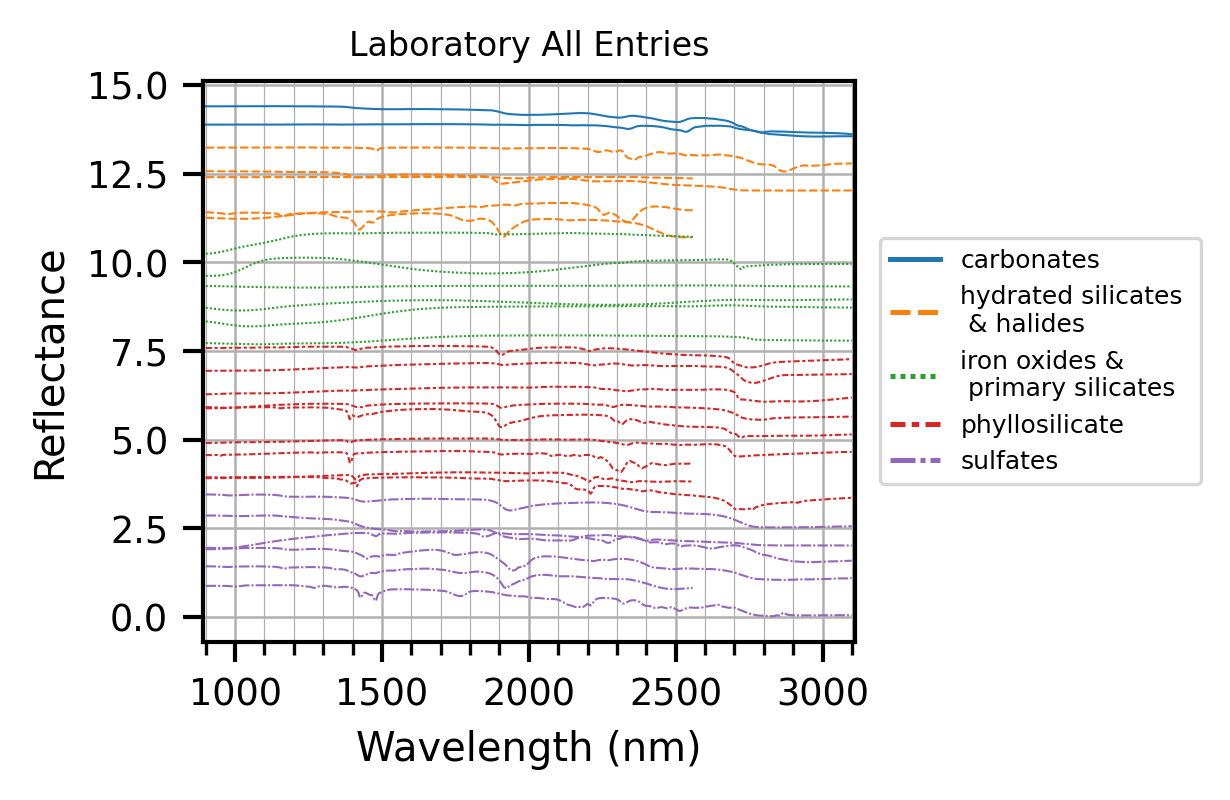

In [8]:
matcol.plot_profiles(categories_only=True)

## Instrument

<p align="center">
  <a href="" rel="noopener">
 <img max-width=512px src="enfys_diagram.png" alt="Enfys Diagram"></a>
</p>

To simulate Enfys, rather than providing a file with the expected spectral response of each position of the Linear-Variable Filter (LVF, above), we specify the spectral range and resolution and sampling regime, and generate a set of central-wavelengths and bandwidths. We do this with the ```InstrumentBuilder``` class of the ```sptk.instrument``` module.

In [9]:
from sptk.instrument import InstrumentBuilder

The expected spectral resolution of Enfys is $\lambda/\Delta\lambda = 100$, and the range is 0.9 - 3.1 µm.

In [25]:
enfys_builder = InstrumentBuilder(
    instrument_name='enfys',
    instrument_type='lvf',
    sampling='nyquist',
    resolution = 100,
    spectral_range=[900, 3100])

Exporting instrument to ../data/instruments/enfys.csv...


In [27]:
enfys_builder.main_df

filter_id          cwl       fwhm
0        S001   909.090909   9.090909
1        S002   913.636364   9.136364
2        S003   918.204545   9.182045
3        S004   922.795568   9.227956
4        S005   927.409546   9.274095
..        ...          ...        ...
239      S240  2994.305270  29.943053
240      S241  3009.276796  30.092768
241      S242  3024.323180  30.243232
242      S243  3039.444796  30.394448
243      S244  3054.642020  30.546420

[244 rows x 3 columns]

In [28]:
from sptk.instrument import Instrument

Now we build the transmission profiles for each LVF position, according to the list of CWLs and FWHMs generated above. These are accessed by reading the ```.csv``` file produced by the ```InstrumentBuilder``` procedure.

When generating the profiles, we turn the CWl and FWHM into a profile by assuming a distribution function. For Enfys we use the Cauchy distribution, which beahves similarly to a Gaussian, but with wider 'wings'. It is parameterised by the full-width-at-half-maximum, as the distribution strictly has no finite variance. We have implemented a ```build_cauchy_filter``` method for the ```Instrument``` class.

In [29]:
enfys = Instrument(
            name = 'enfys', # filename of the instrument information, held in /software/data/instruments/            
            project_name = matcol.project_name, # the project directory name, hosting outputs in the /spectral_parameter_studies/ directory
            shape = 'cauchy',
            load_existing=False, # if True, load existing instrument data from the project directory
            plot_profiles=False, # if true, plot the transmission profiles during construction
            export_df=True) # if True, export the instrument transmission profiles to the project directory

Building Instrument...
Building new DataFrame for 'enfys'...
Exporting the Instrument to CSV and Pickle formats...


Plotting Instrument Transmission...


/Users/sci/Documents/software/sptk/src/sptk/instrument.py:451: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Plots exported to ../projects/enfys_mica/instrument


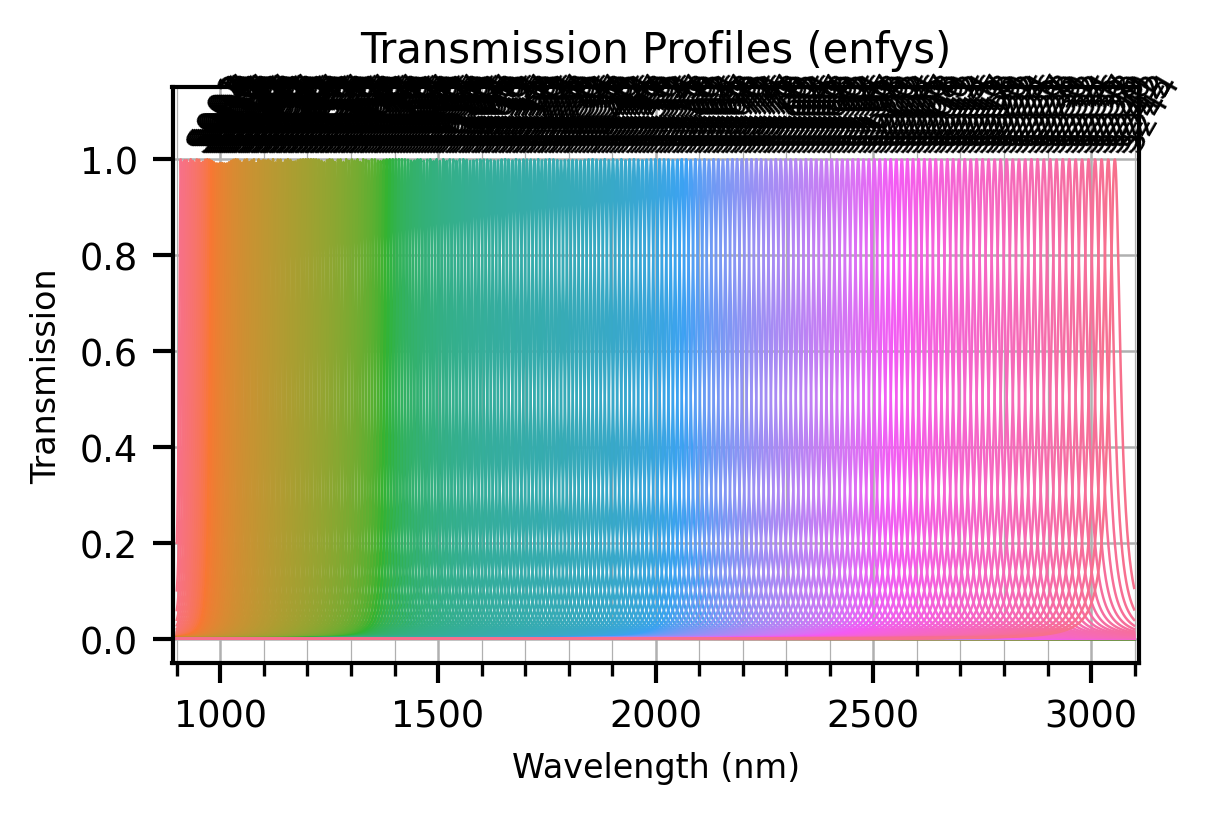

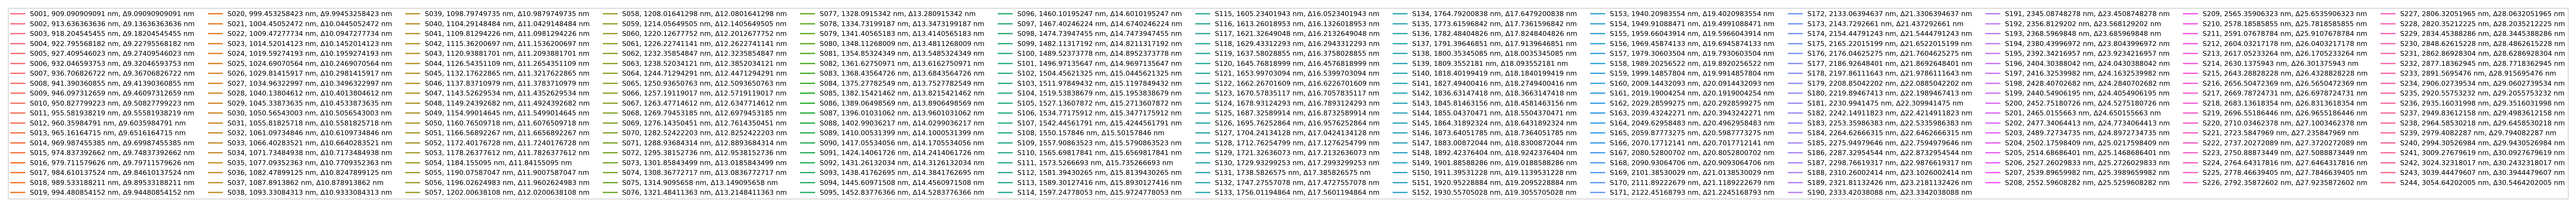

In [30]:
enfys.plot_filter_profiles()

This crude plot illustrates all of the linear-variable-filter positions considered here, under Nyquist sampling. That, the interval between each CWL is FWHM / 2. This gives 244 channels over 0.9 - 3.1 µm.

# Sampling MICA with Enfys

We now make an ```Observation``` object by sampling the MICA files ```MaterialCollection``` with the Enfys ```Instrument```.

In [31]:
from sptk.observation import Observation

In [32]:
obs = Observation(
    material_collection=matcol,
    instrument = enfys,
    load_existing=False,
    plot_profiles=False,
    export_df=True)

Building new Observation DataFrame                                                  for 'enfys_mica'...
Sampling the Material Collection with the Instrument...
Sampling complete.
Exporting the Observation Pickle format...
Observation export complete.


In [33]:
obs.main_df[obs.wvls[0]]

Data ID
Fayalite LAPO05               0.219454
Forsterite LASC02             0.320922
Hematite GDS27                0.254864
Orthopyroxene LAPP47B         0.122229
Plagioclase NCLS04            0.329185
Pyroxene NBPP22               0.205802
Alunite F1CC08B               0.869331
Bassanite GDS145              0.920403
GYPSUM LASF41A                0.942399
Jarosite LASF21A              0.408402
Kieserite F1CC15              0.853809
Magnesium-Sulfate 799F366     0.947693
Chlorite LACL14               0.278081
Illite LAIL02                 0.439245
Kaolinite LAKA04              0.932968
Margarite GDS106              0.409146
Montmorillonite LAMO02        0.579698
Nontronite NCJB26             0.382527
Saponite LASA58               0.909082
Serpentine LALZ01             0.402390
Talc GDS23                    0.563223
Calcite CAGR01                0.883960
Magnesite F1CC06B             0.900589
Analcime GDS1                 0.905417
Epidote GDS26                 0.254573
Halite HS433     

We can plot the sampled spectra against the input high-spectra below:

/Users/sci/Documents/software/sptk/src/sptk/spectral_library_analyser.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=fig_size, dpi=cfg.DPI)


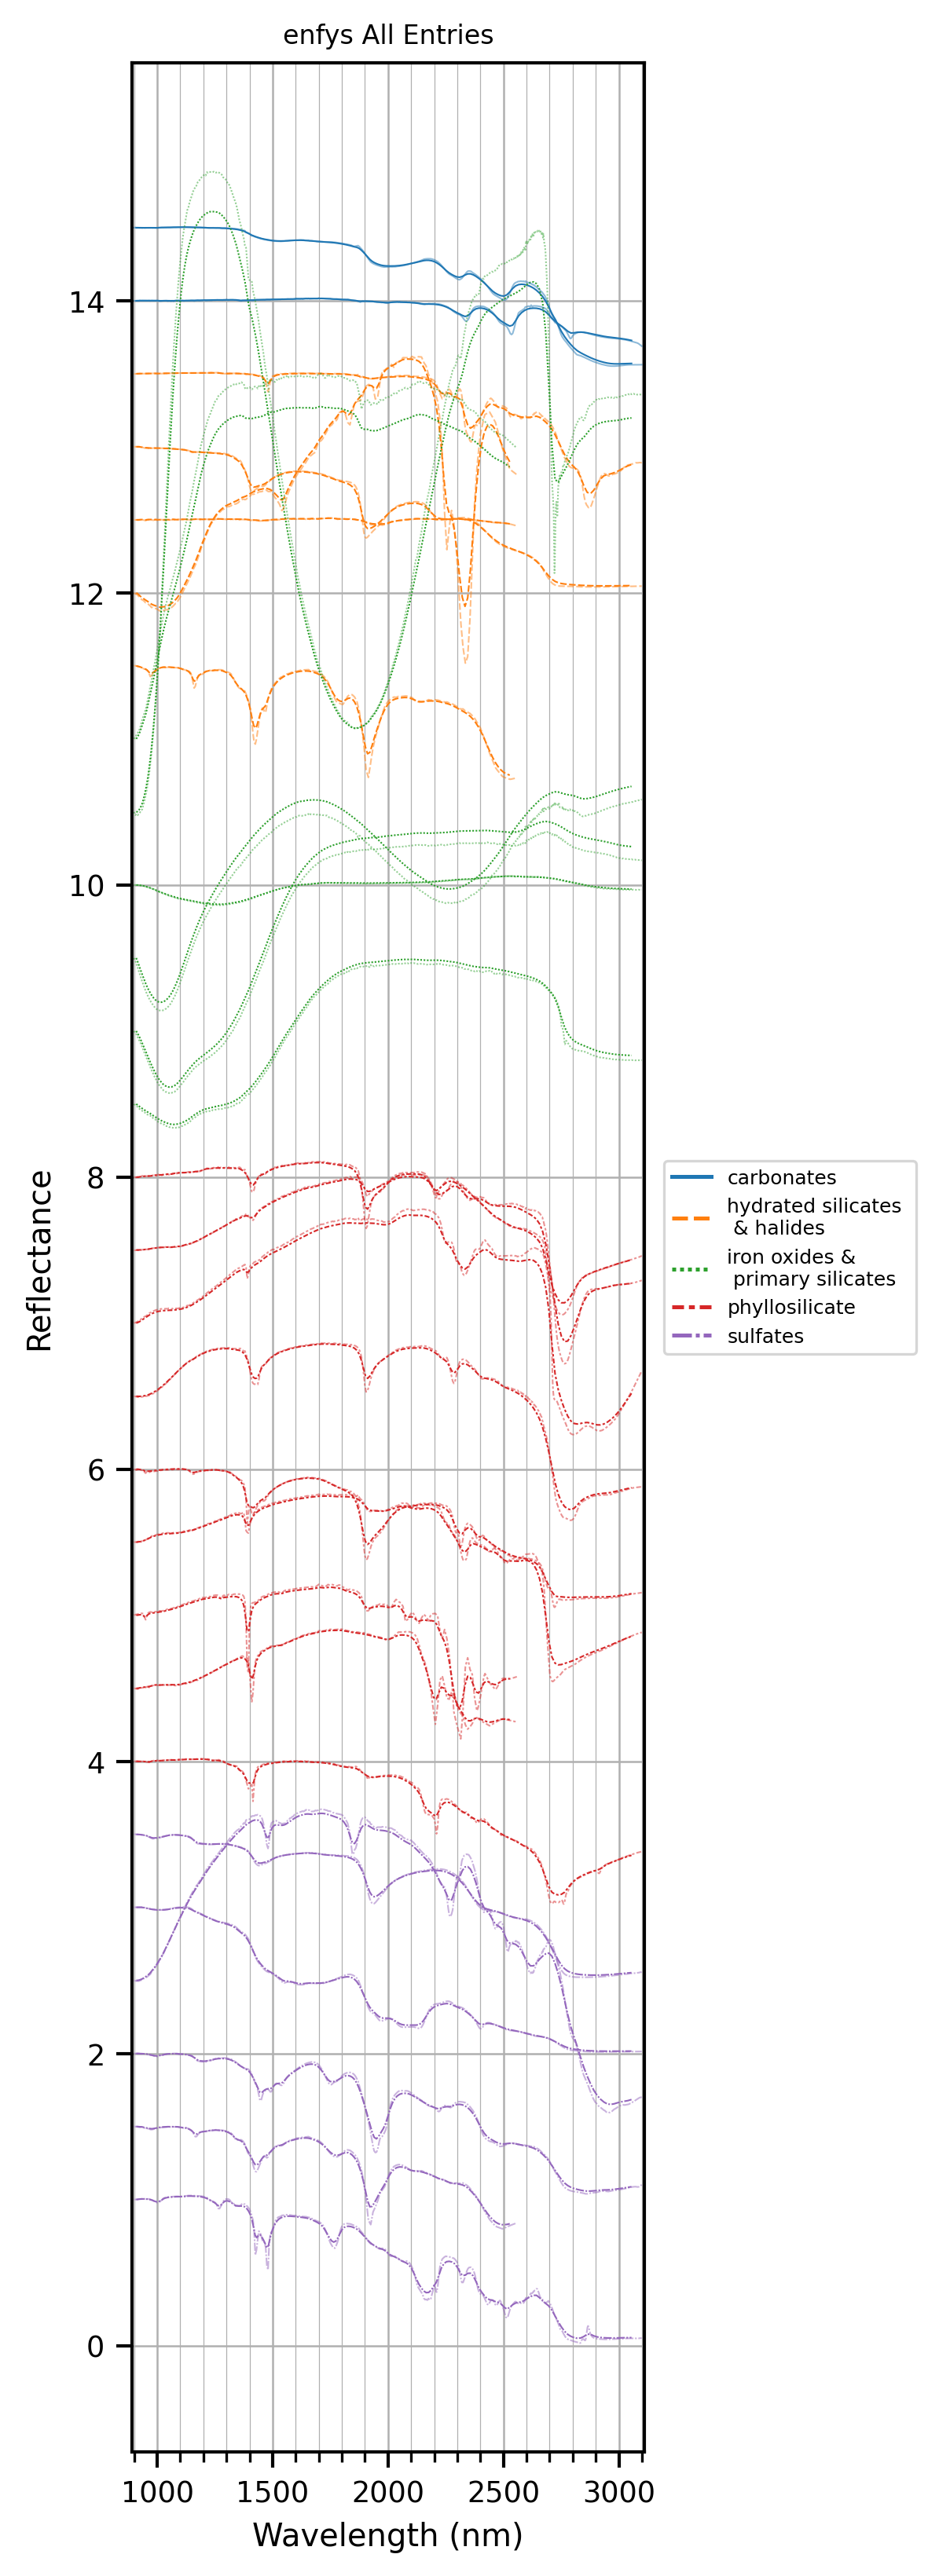

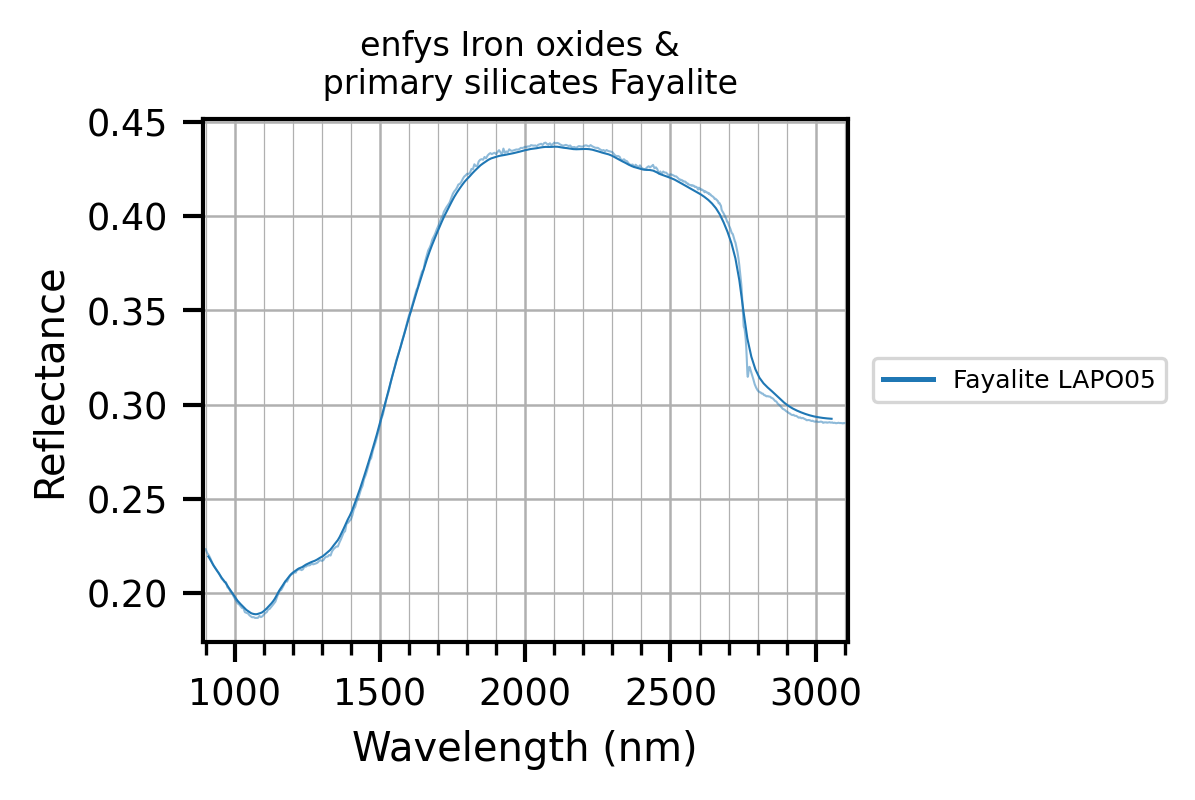

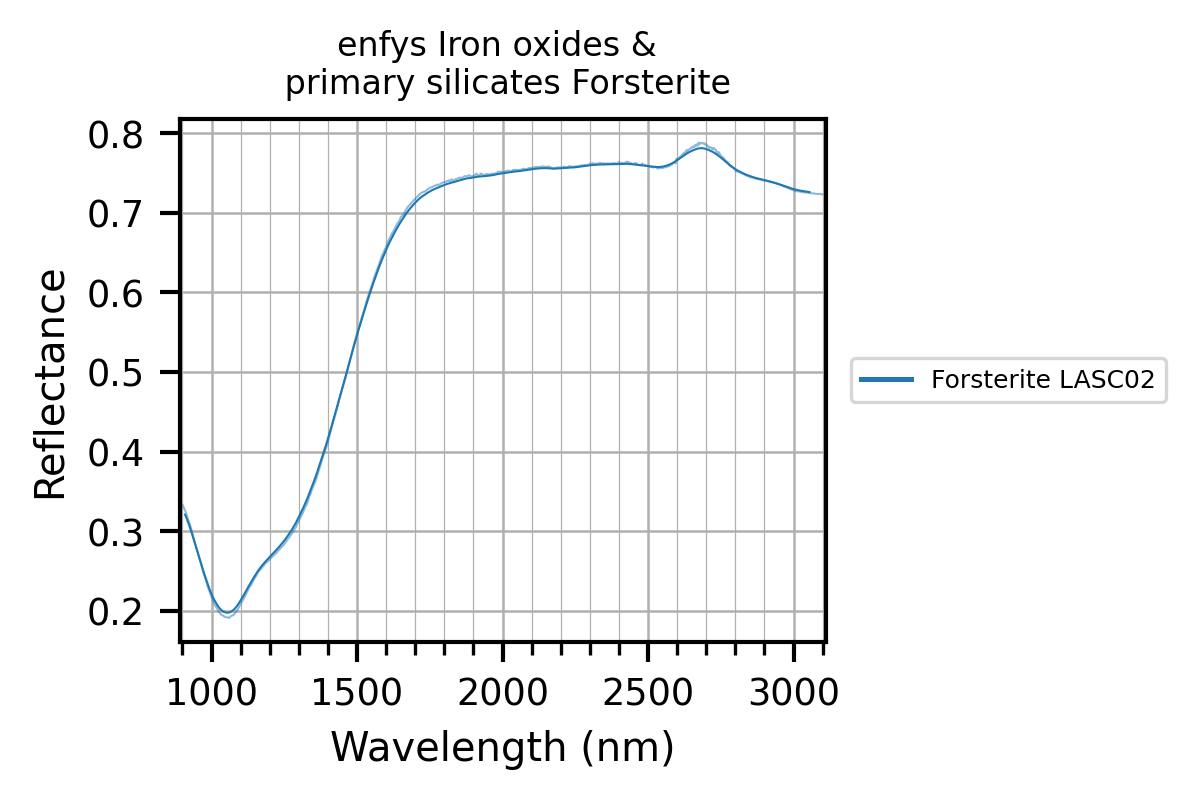

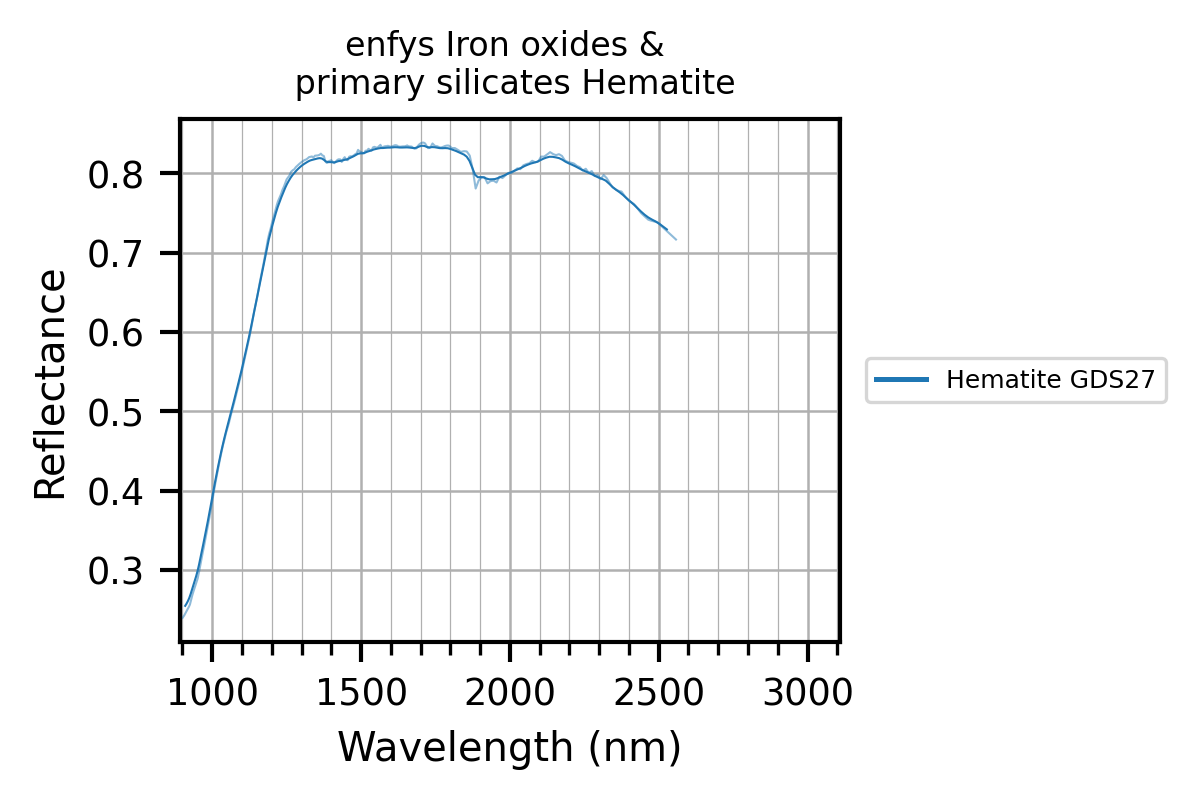

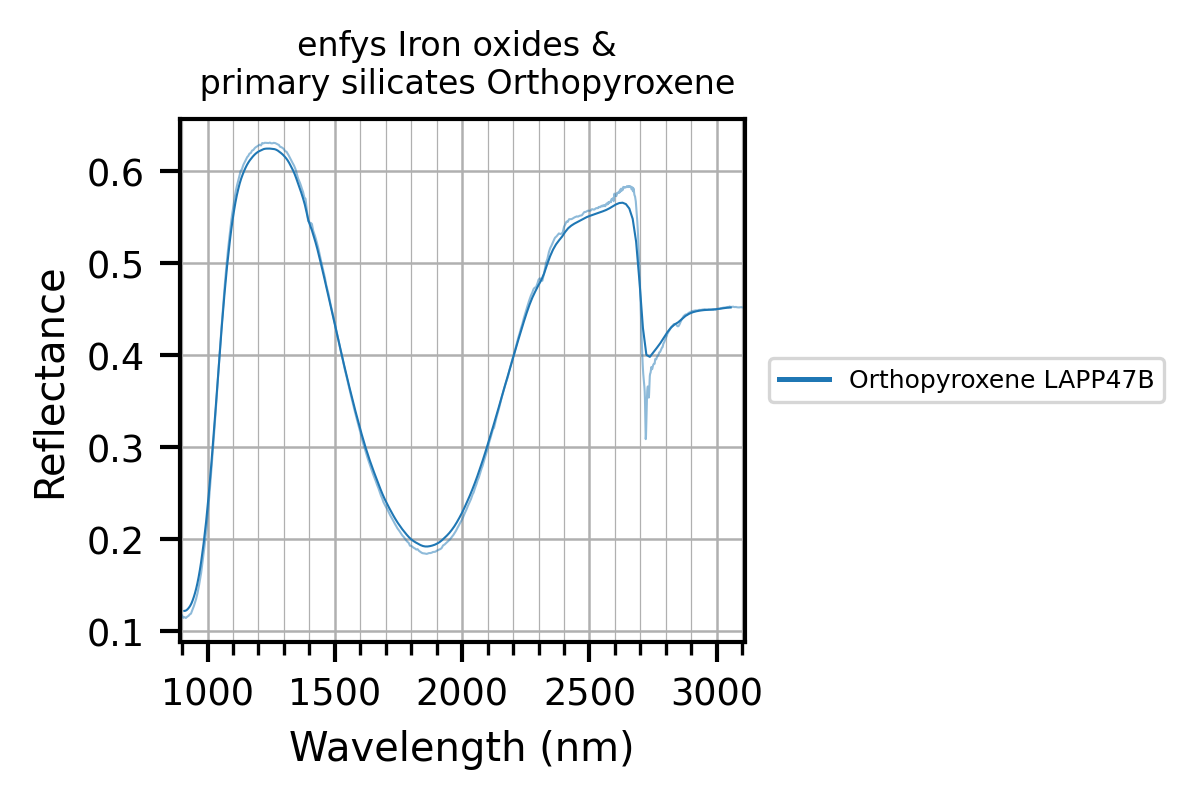

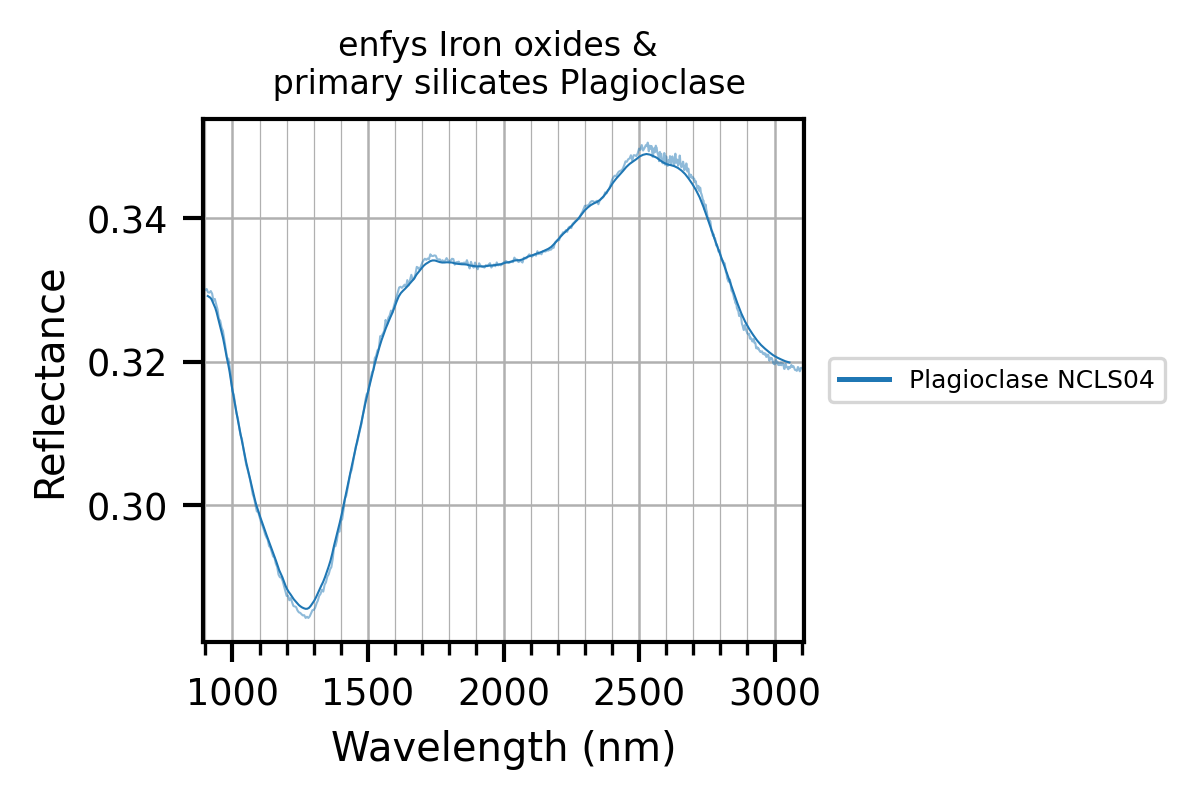

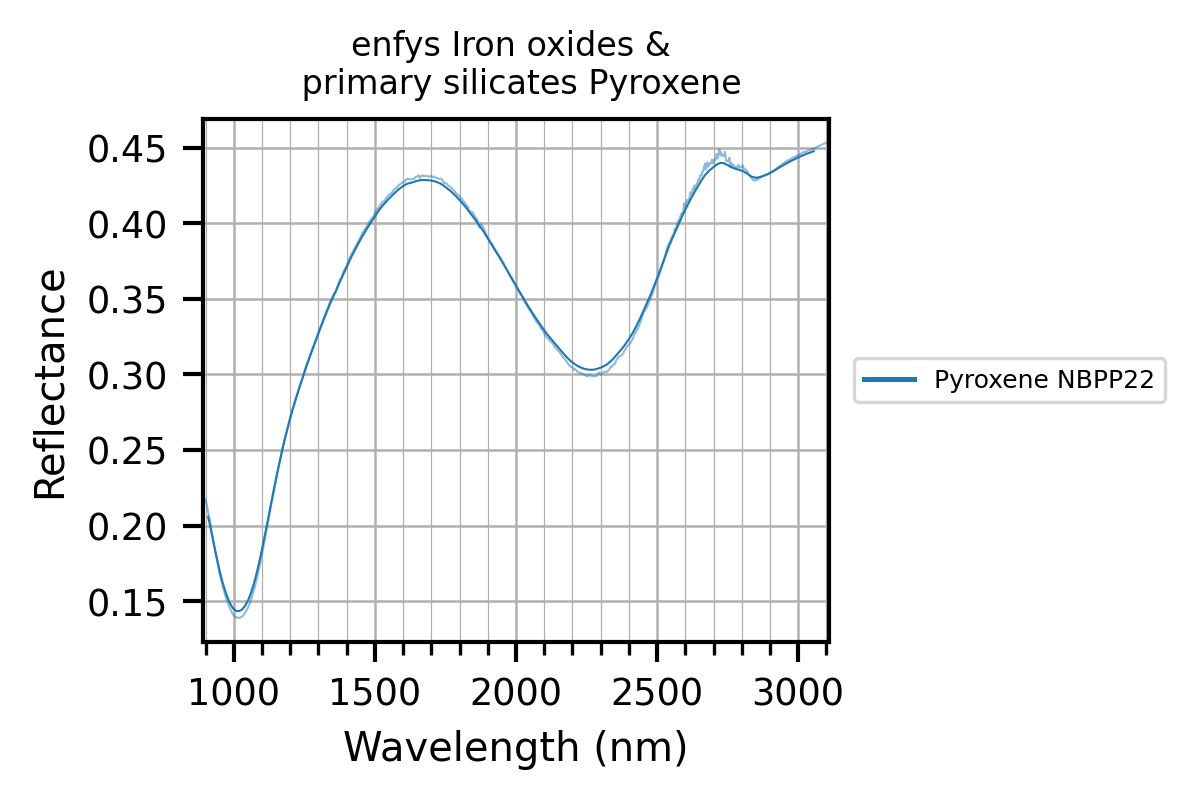

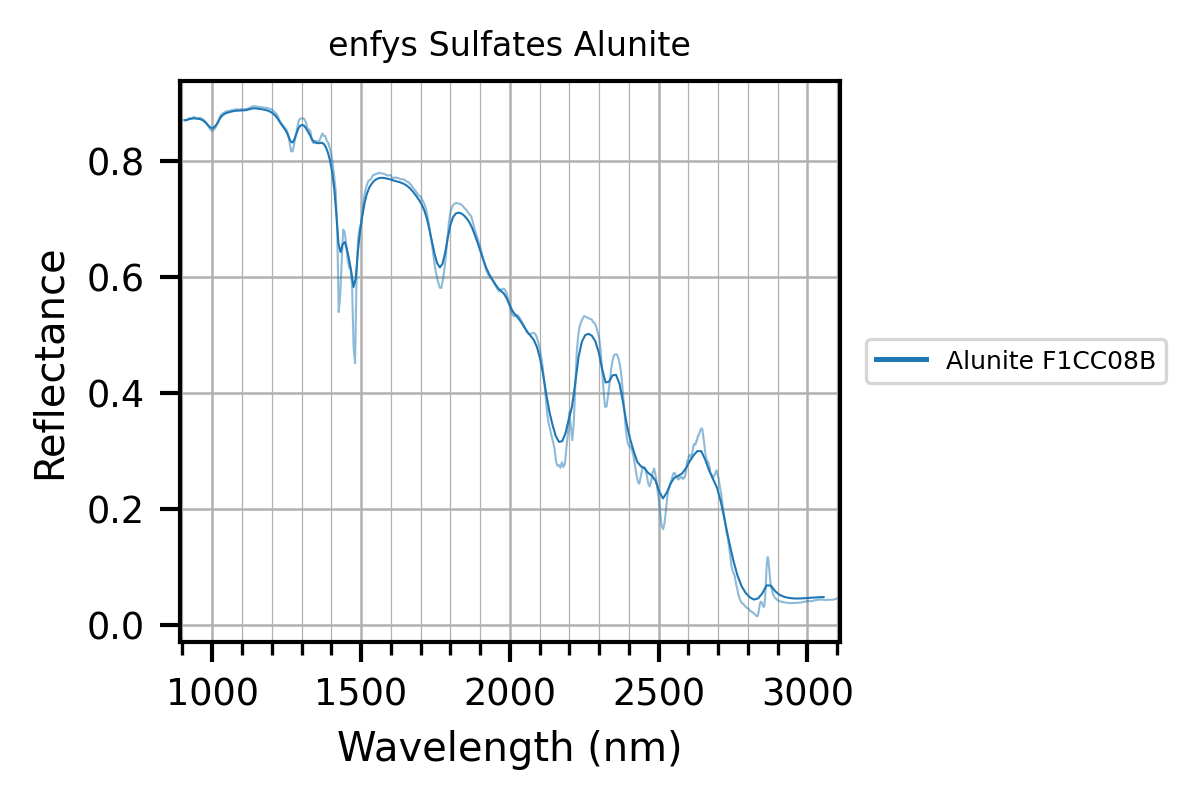

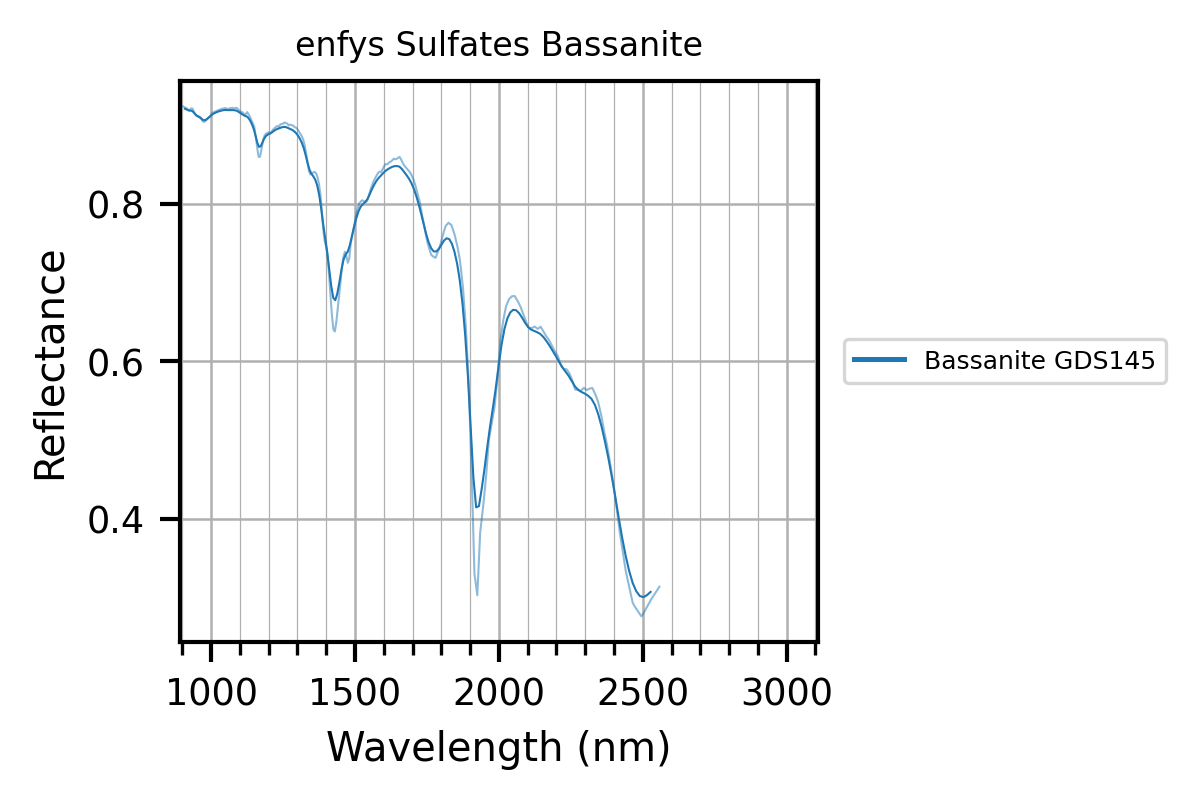

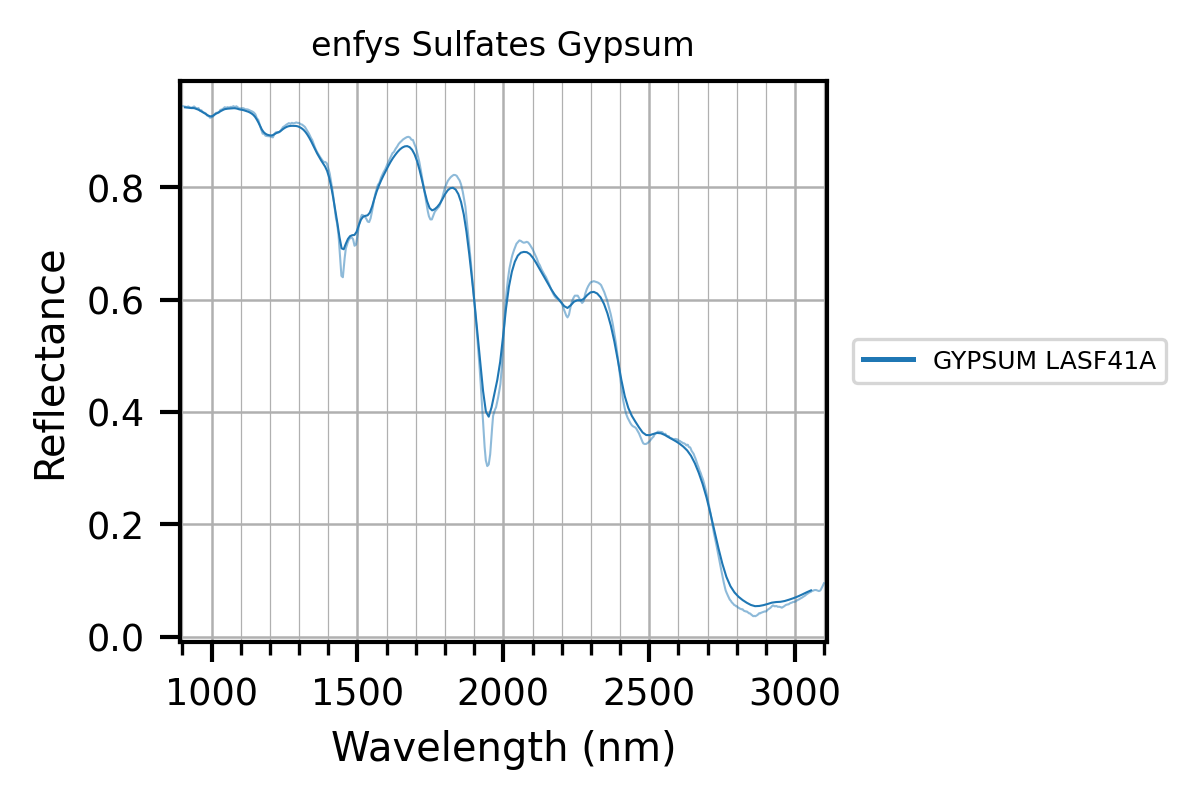

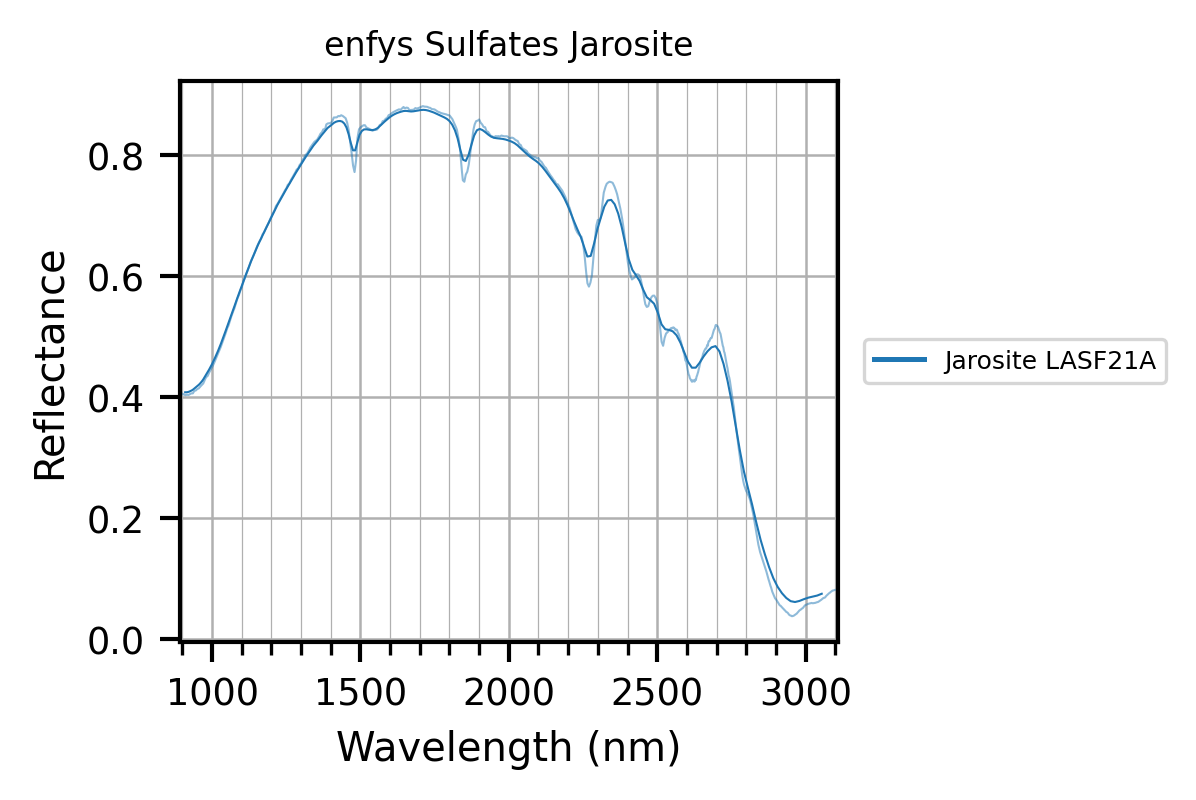

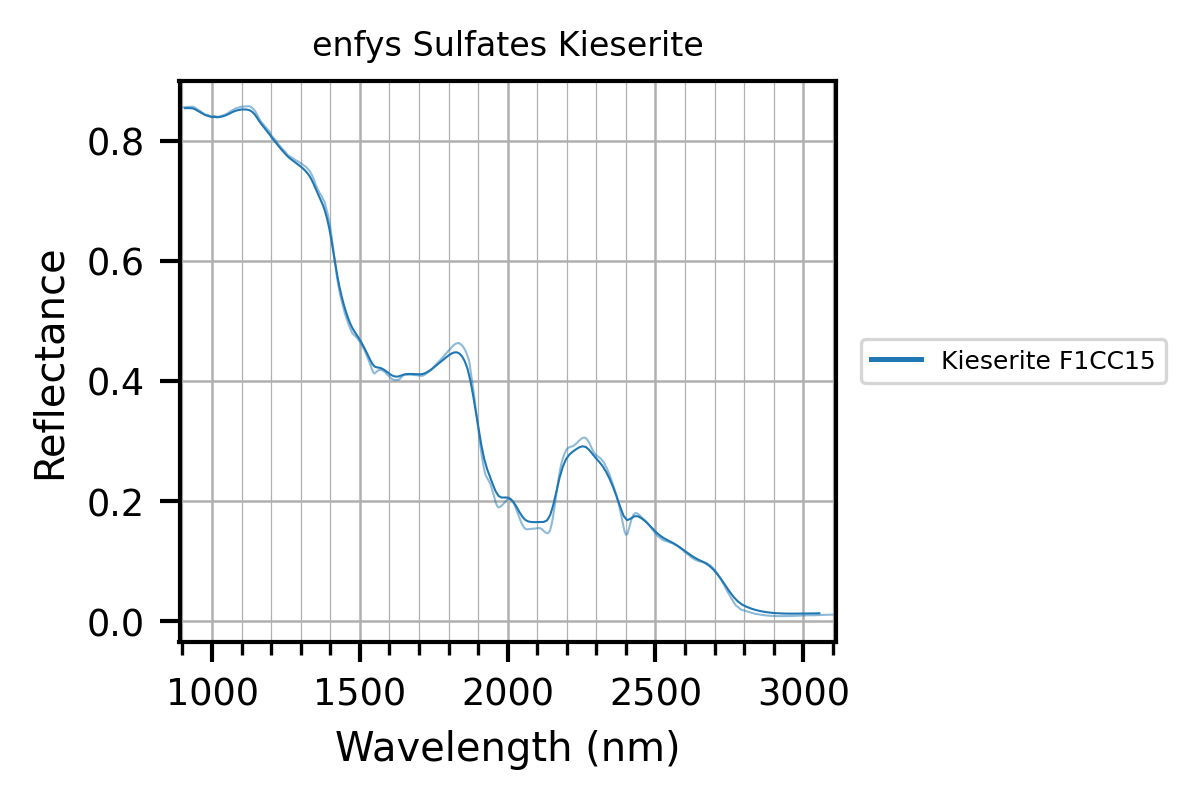

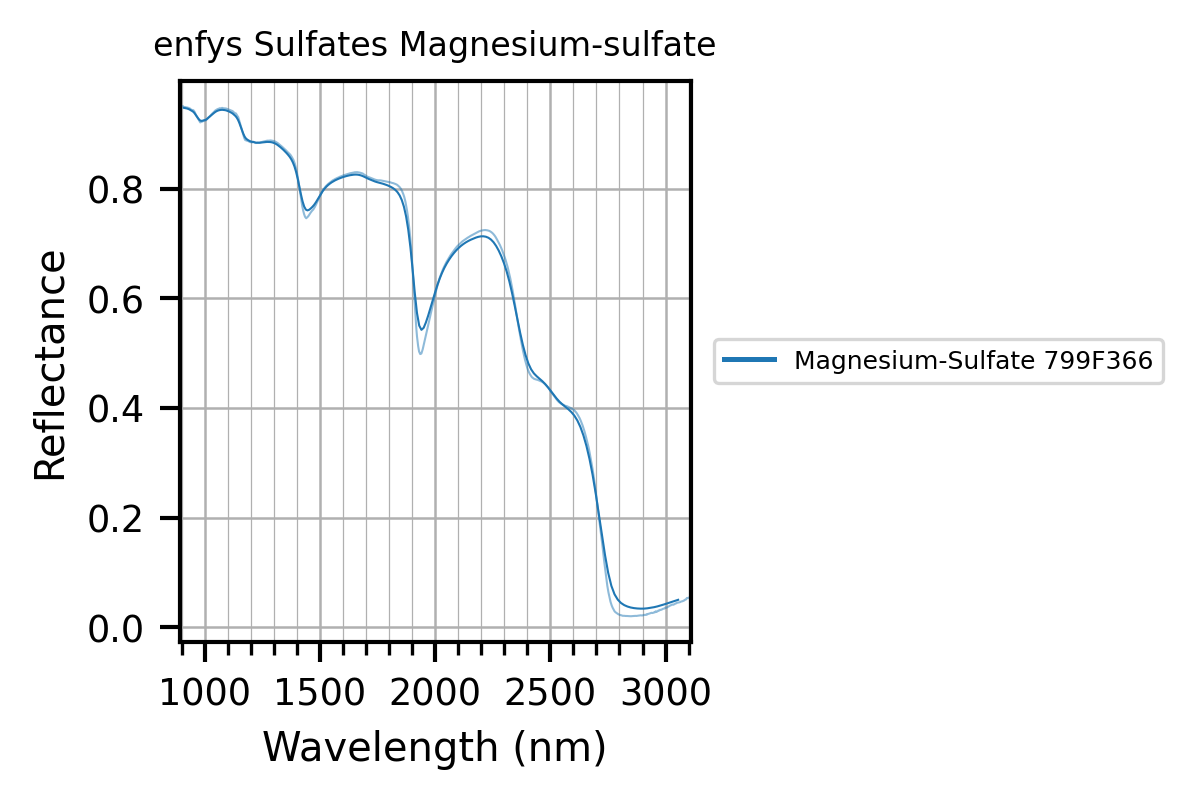

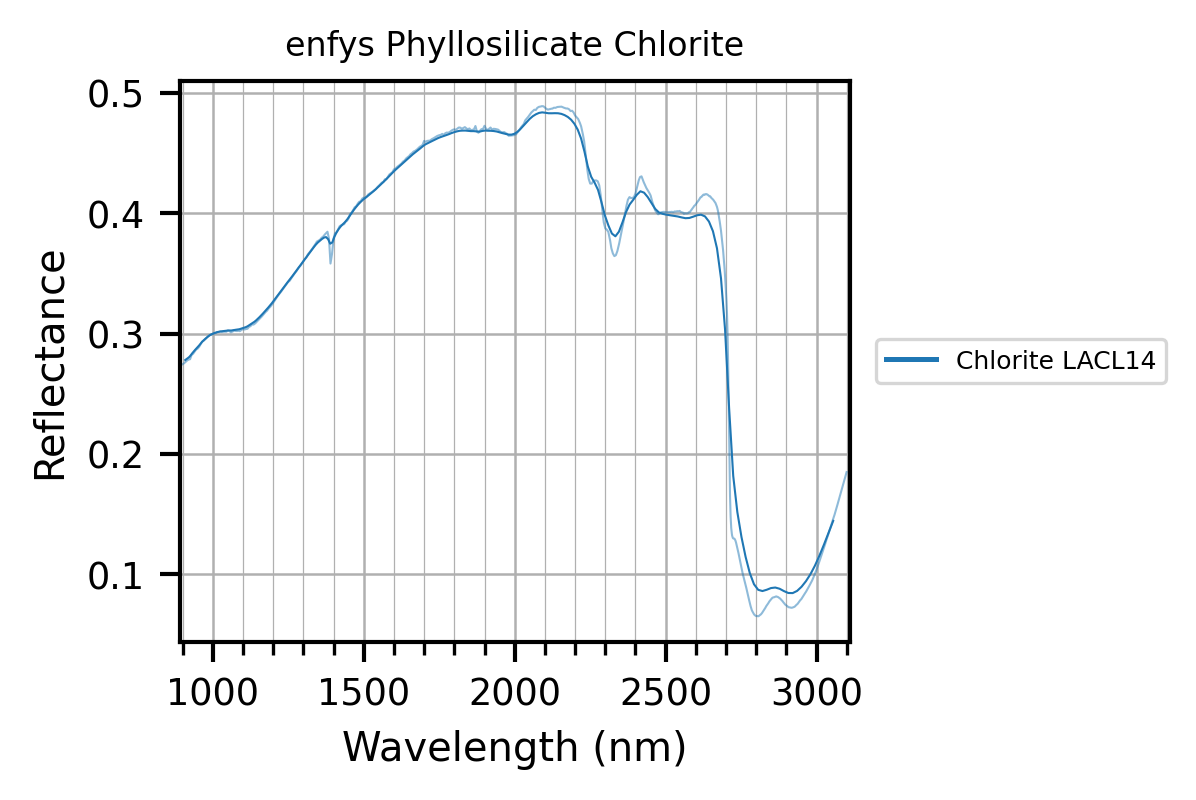

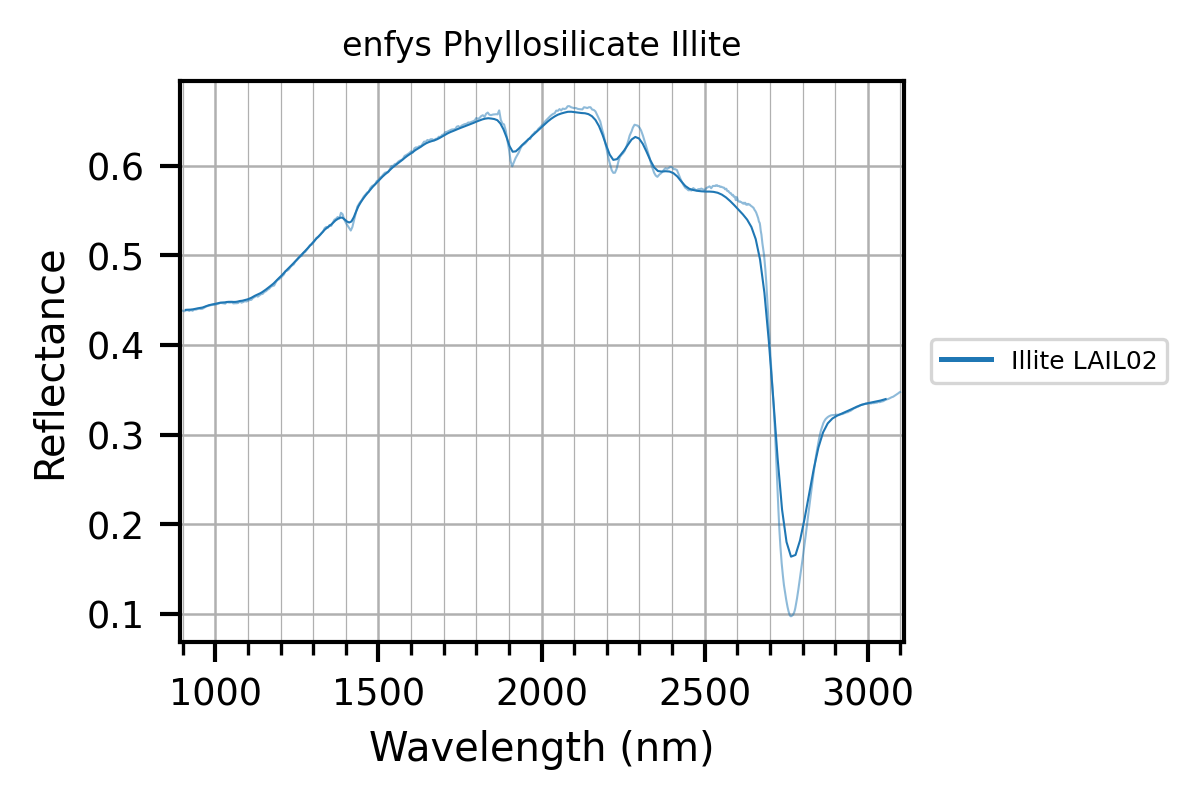

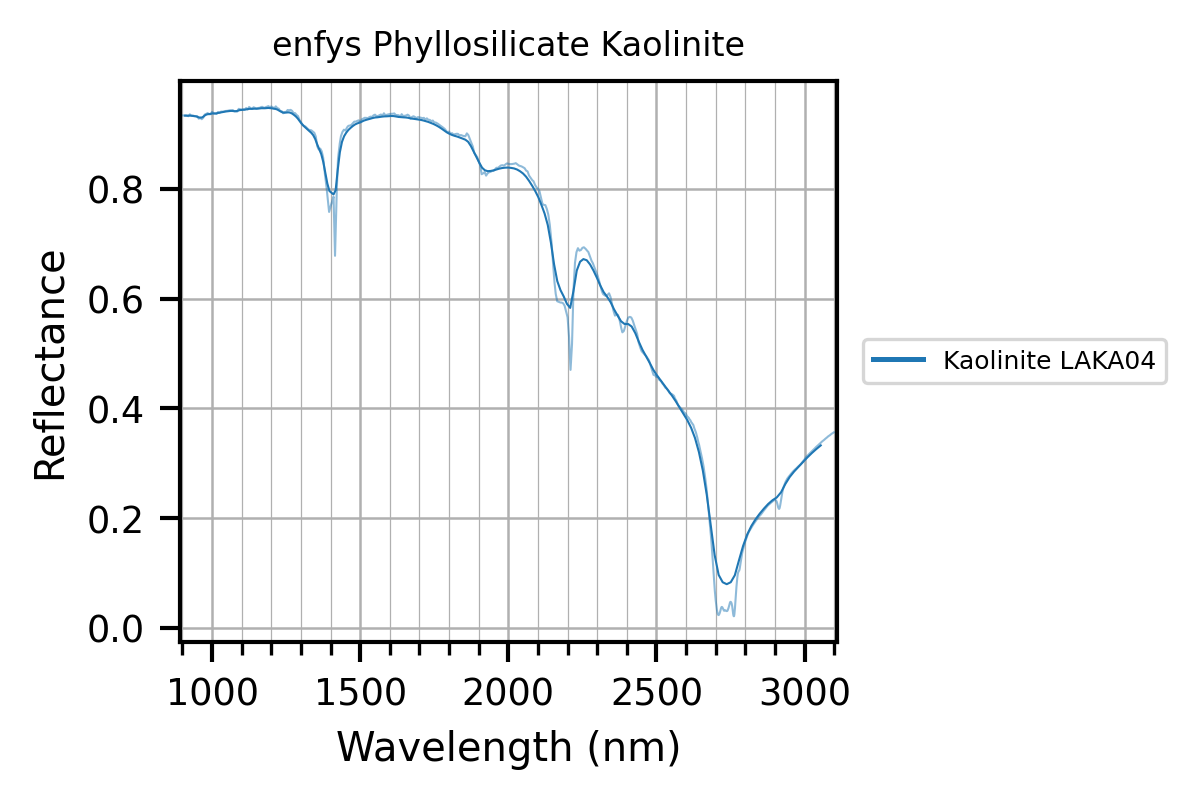

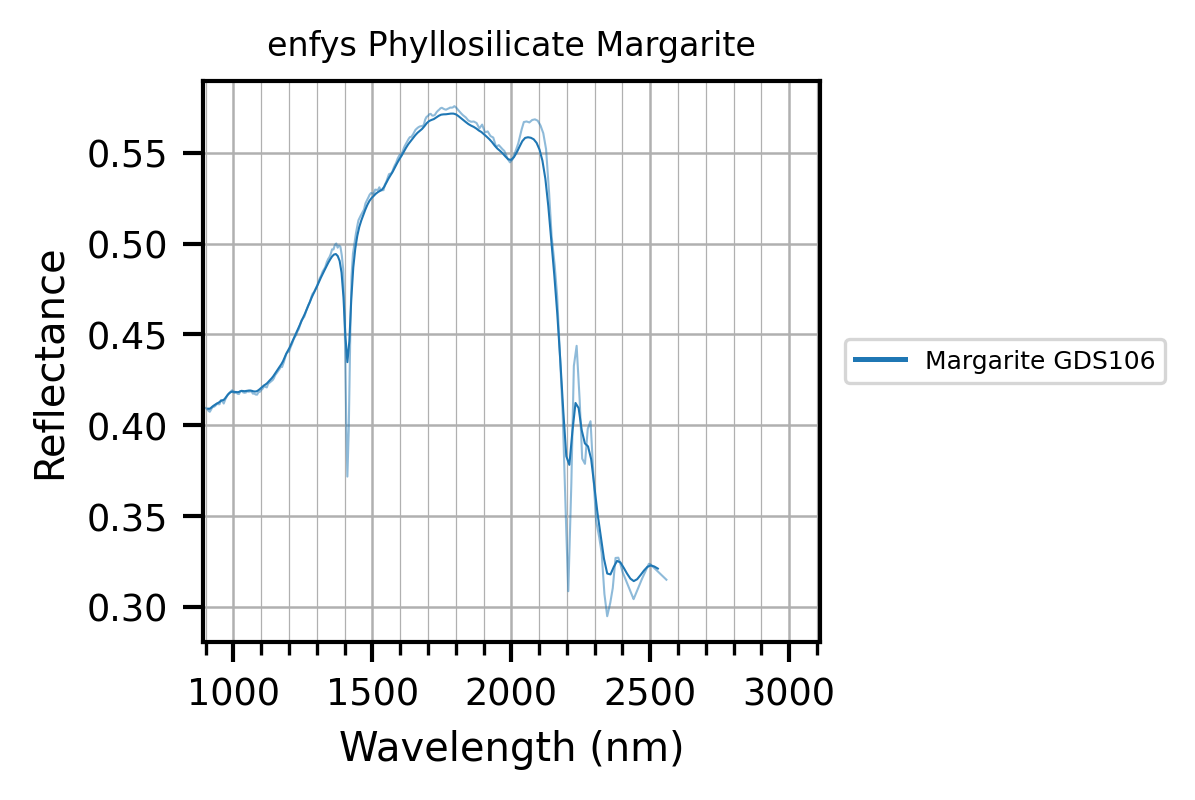

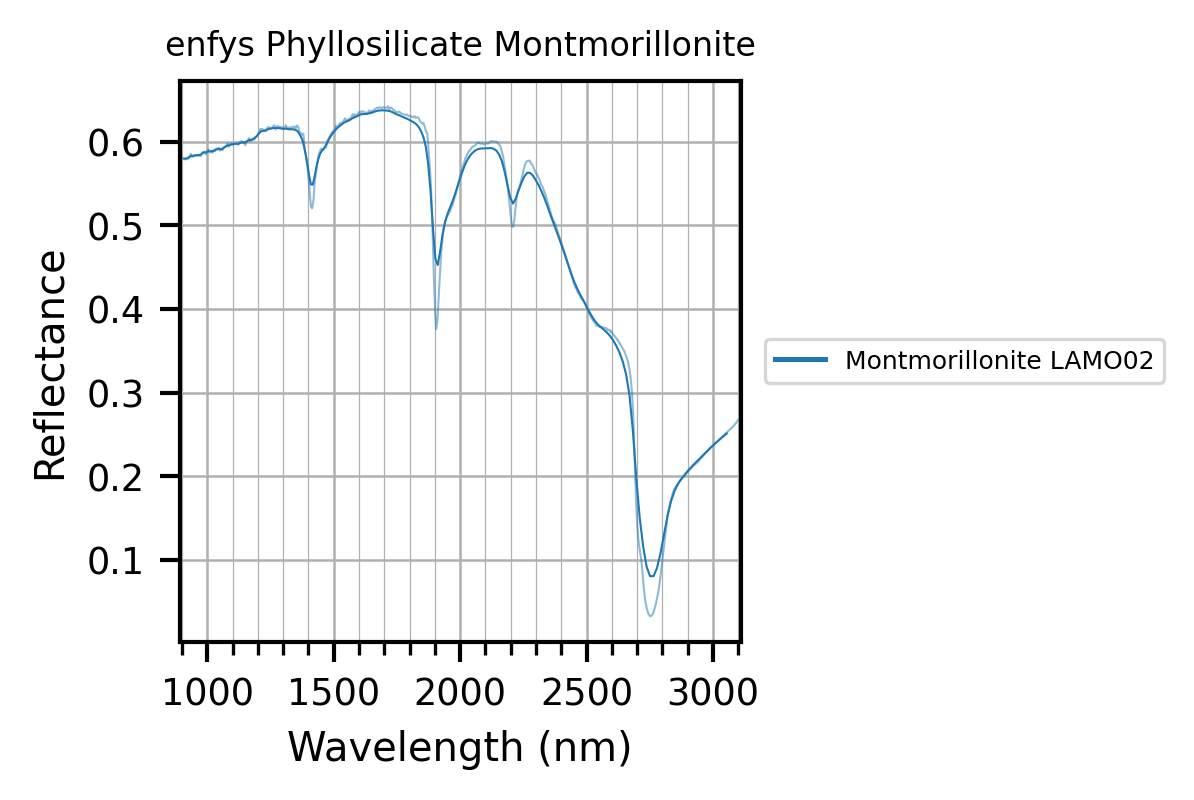

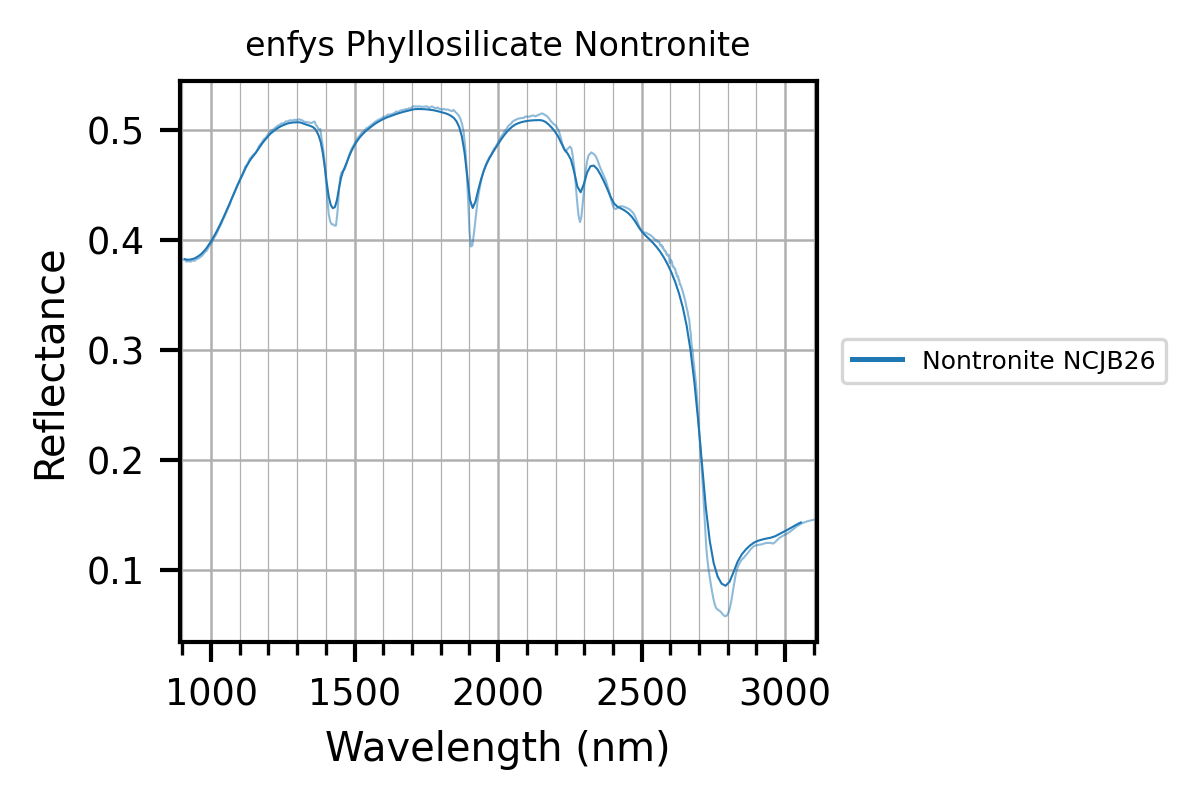

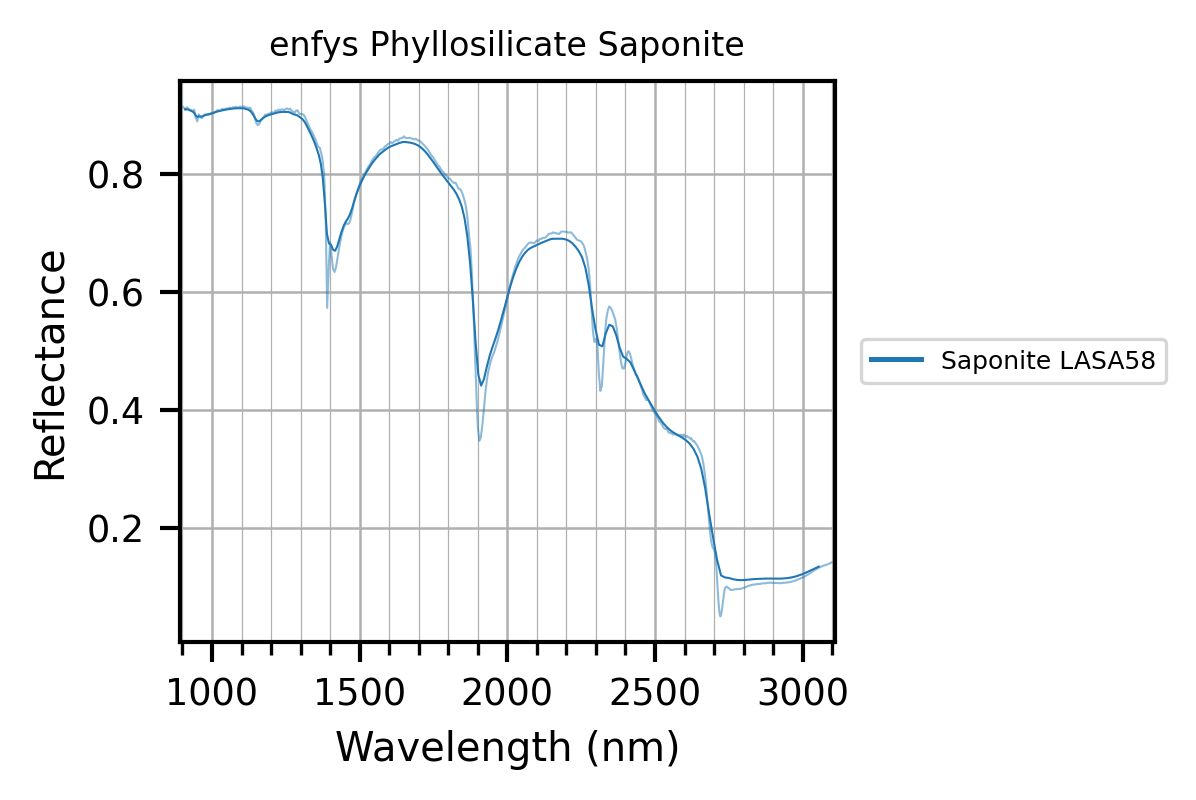

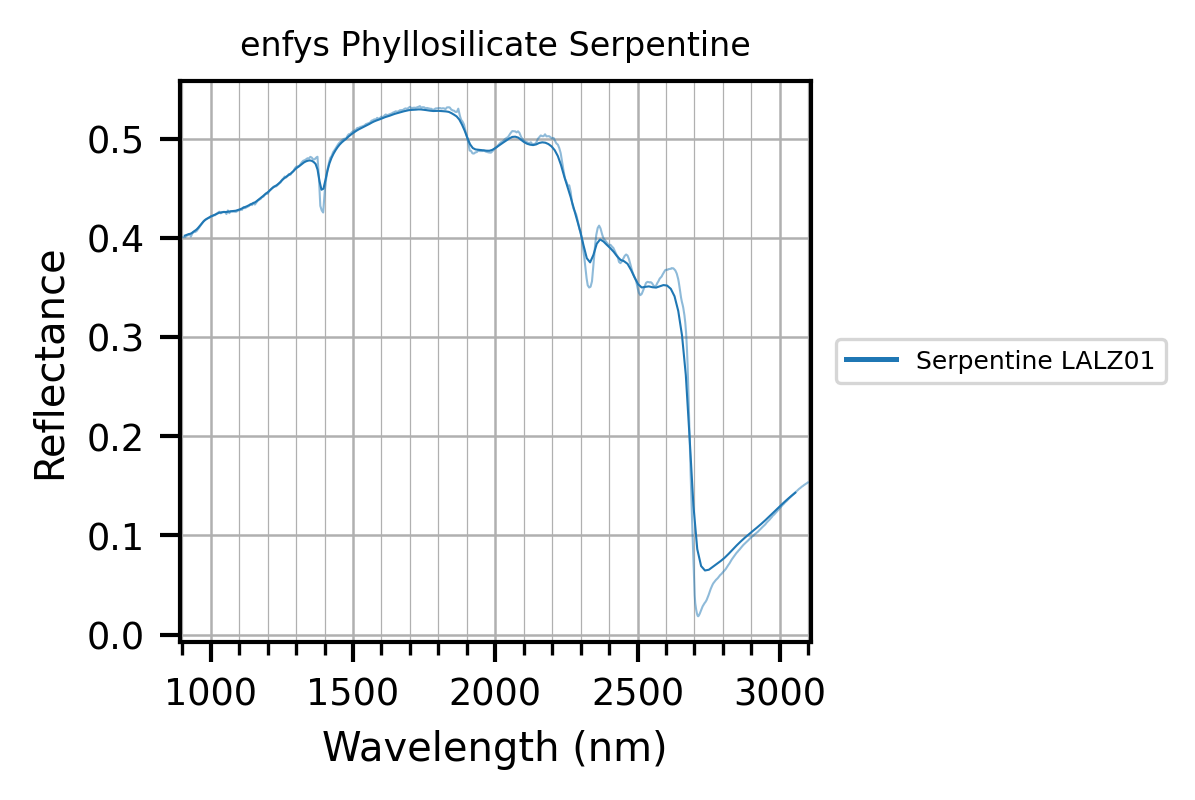

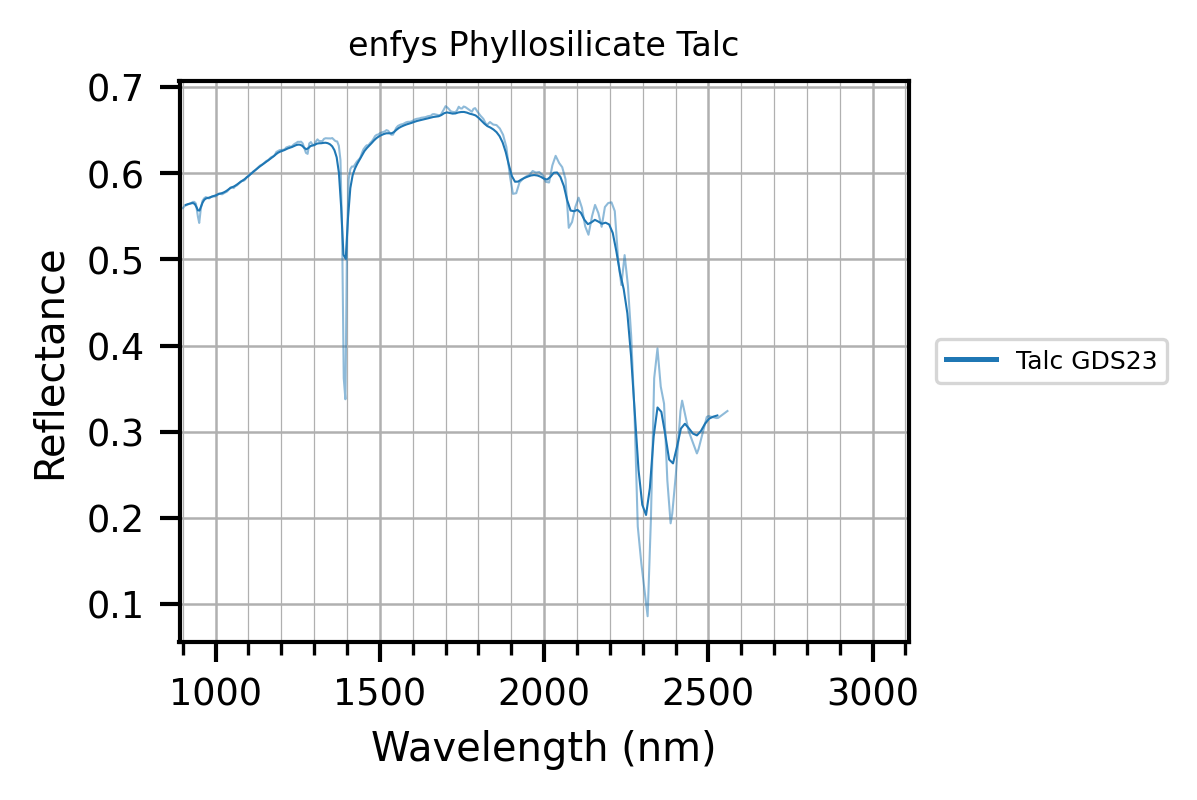

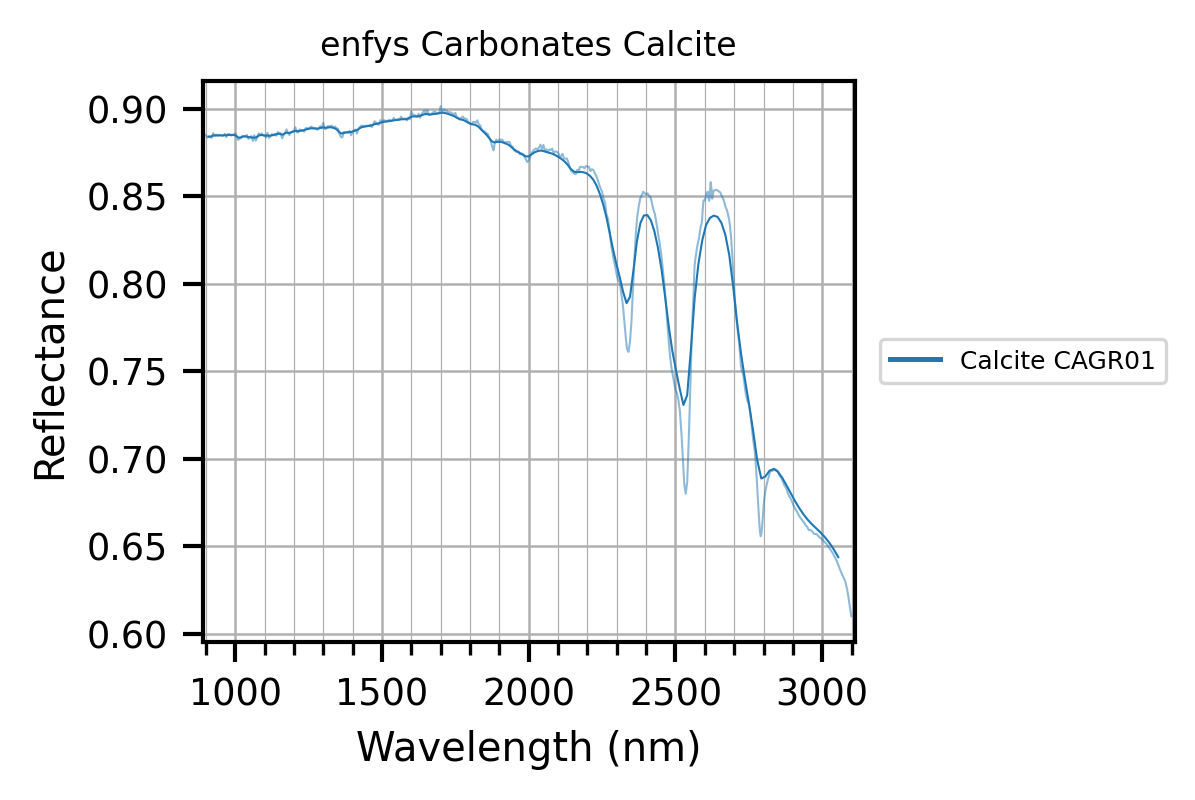

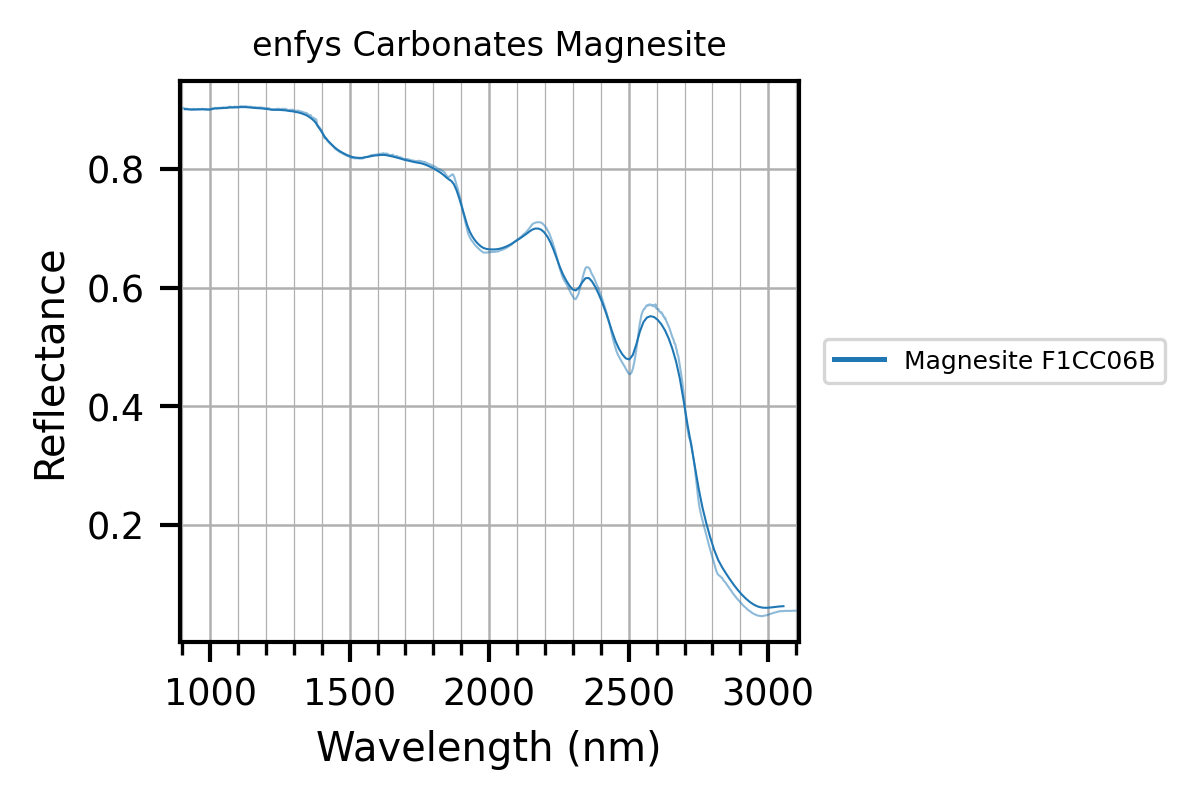

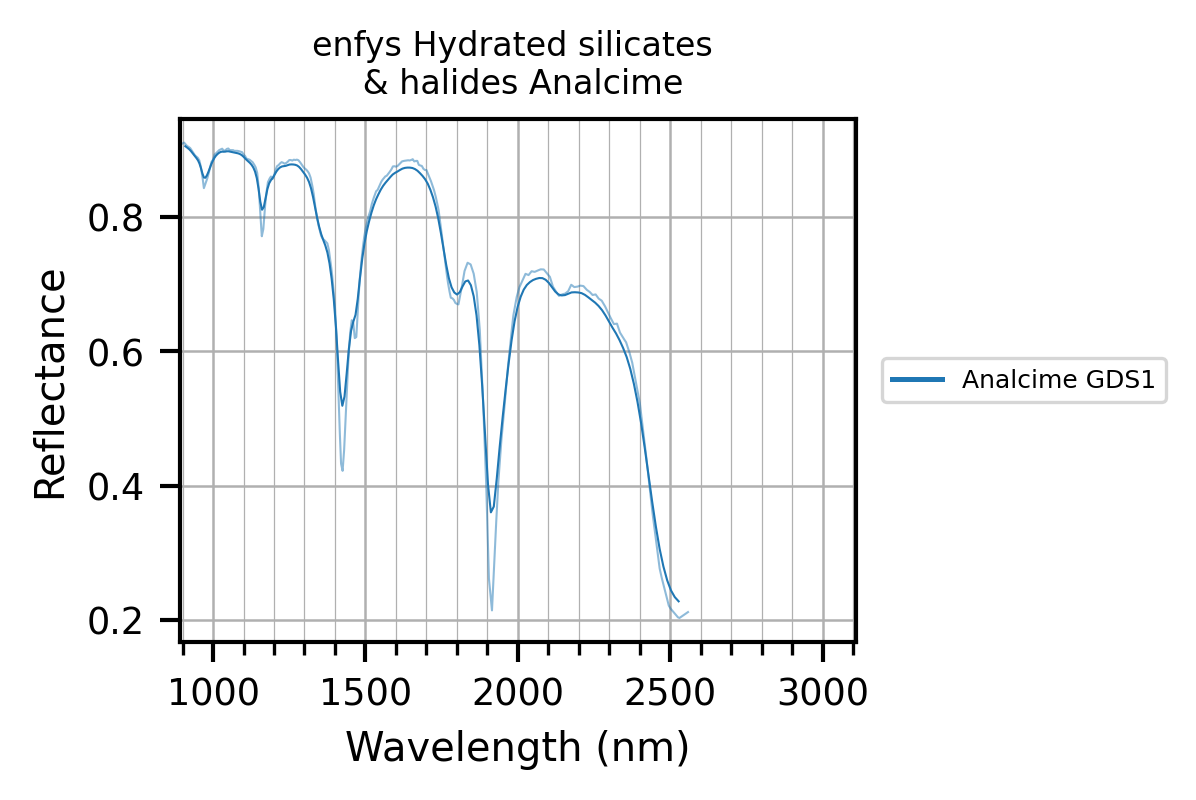

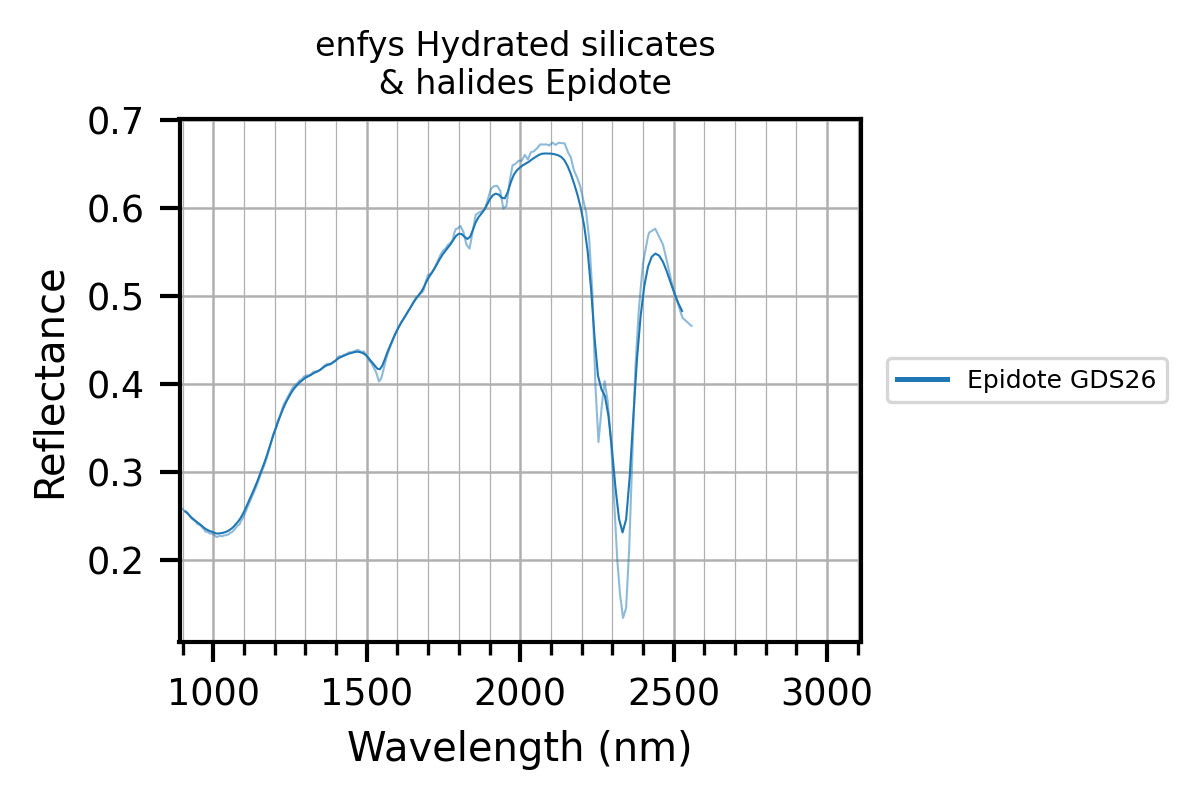

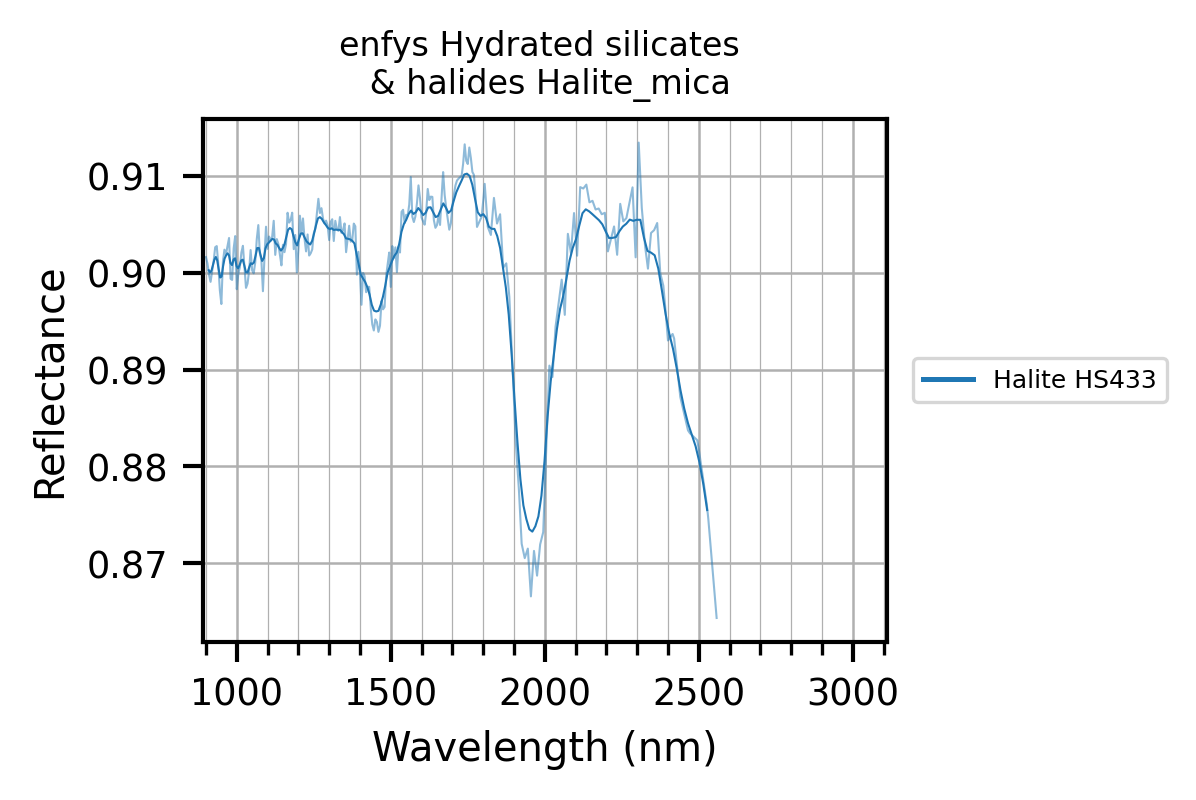

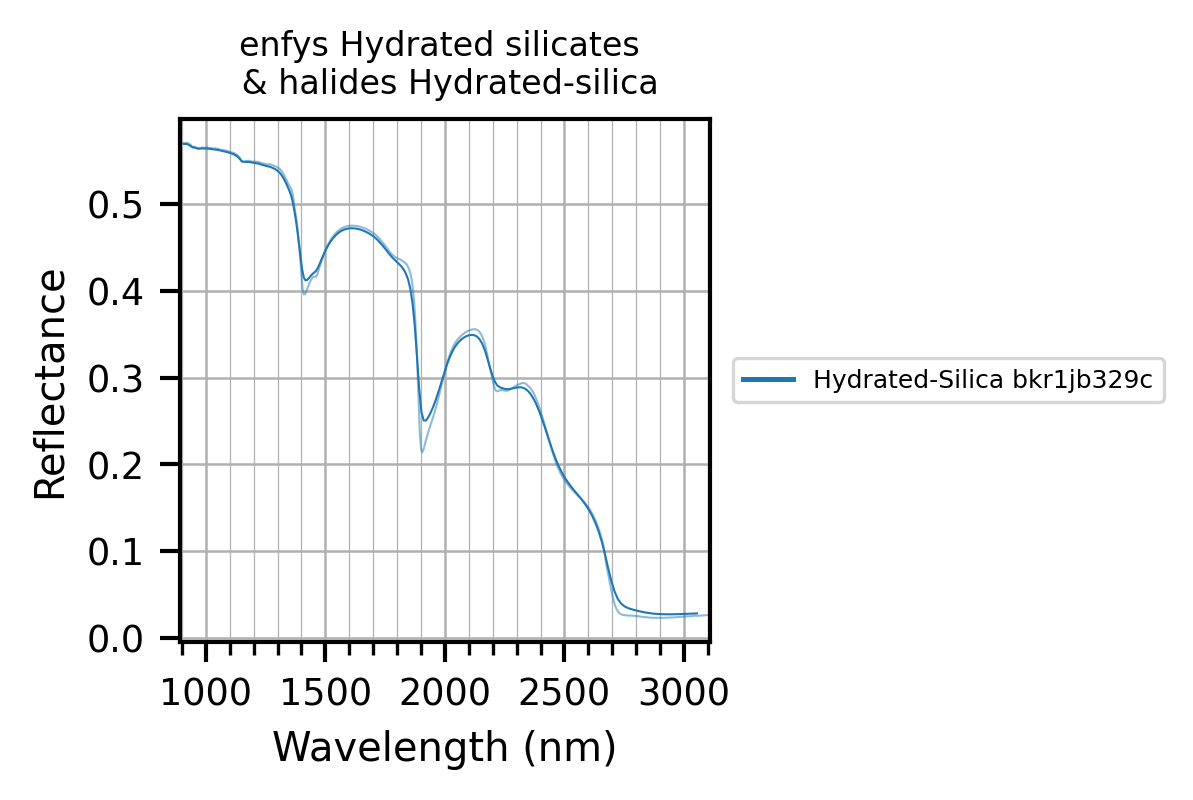

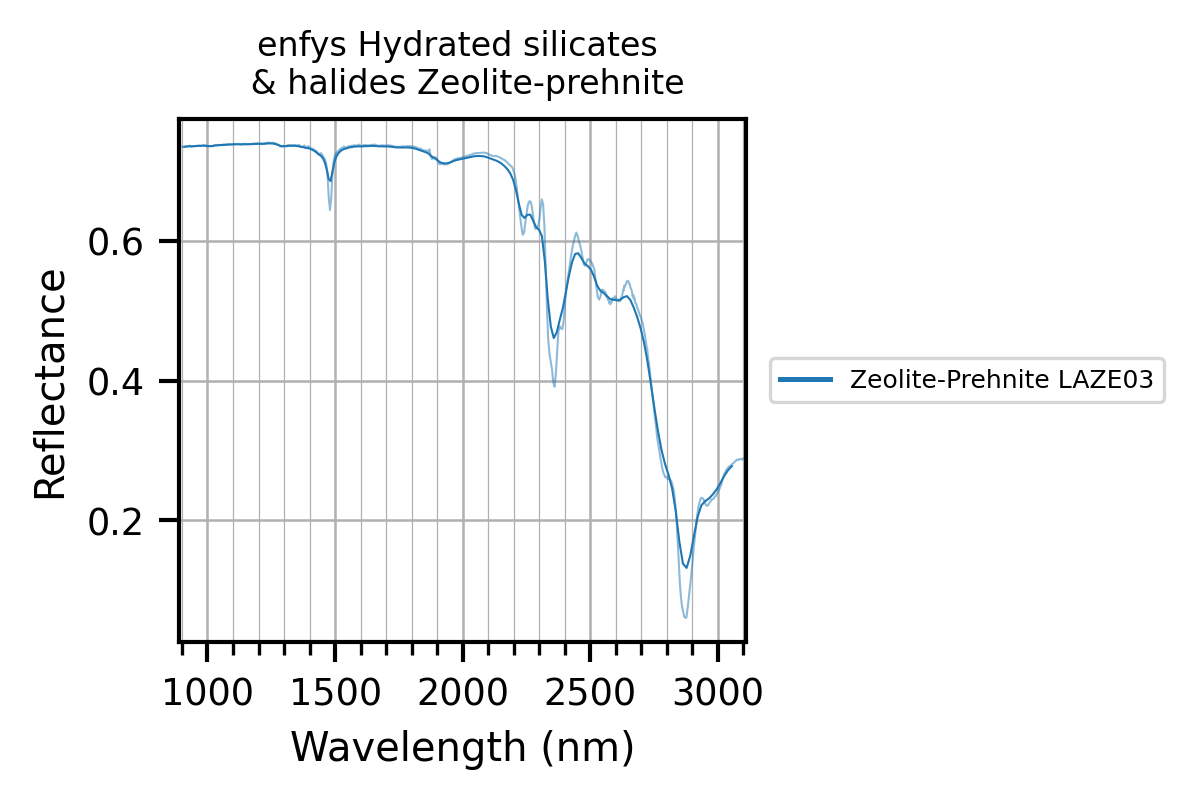

In [41]:
axes = obs.plot_profiles(hires_under=True)

To collect the spectra together in an easy to visualise way, we can also produce a 'spectrogram'.

In [ ]:
from sptk.spectral_library_analyser import SpectralLibraryAnalyser as sla

In [ ]:
plottr_mc = sla(matcol)

In [ ]:
cr_df = plottr_mc.remove_continuum()

In [ ]:
fig, ax = plottr_mc.visualise_spectrogram()

Now we look at the Enfys sampled library:

In [ ]:
plotter = sla(obs)

In [ ]:
plotter.remove_continuum()

In [ ]:
fig, ax = plotter.visualise_spectrogram()

By comparing the Material Collection high resolution spectrograph to the Enfys sampled spectrograph, we can get an idea of the resolution of Enfys.

In [ ]:
plotter.analyse_bands()